# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### 1. Read the images

In [1]:
import os
import glob

# Read the car images
basedir = 'vehicles/'
image_types = os.listdir(basedir)

cars = []
for image_type in image_types:
    cars.extend(glob.glob(basedir + image_type + '/*'))

print('Number of car images found', len(cars))

with open('cars.txt', 'w') as f:
    for imgs in cars:
        f.write(imgs+'\n')
        
# Read the non car images
basedir = 'non-vehicles/'
image_types = os.listdir(basedir)

notcars = []
for image_type in image_types:
    notcars.extend(glob.glob(basedir + image_type + '/*'))

print('Number of non-car images found', len(notcars))

with open('noncars.txt', 'w') as f:
    for imgs in notcars:
        f.write(imgs+'\n')     

Number of car images found 8792
Number of non-car images found 8968


## 2. Load helper functions

#### Define different feature extraction functions

In [2]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    #print('bin_spatial', features.shape)
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#### Extract features for images

In [3]:
def convert_from_rgb(img, color_space):
    image = img
    if color_space == 'HSV':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    return image

# Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = convert_from_rgb(img, color_space)
            
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
        #print('spatial', spatial_features.shape)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
        #print('hist', hist_features.shape)        
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        #print('hog', np.array(hog_features).shape)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img = mpimg.imread(file)
        #print('img read', img.shape)
        img_features = single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(img_features)
    # Return list of feature vectors
    return features

#### Sliding windows and drawing bounding boxes

In [4]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#### Search windows

In [5]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def visualize(figs, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
        

#### Visualize

In [6]:

#sample_size = 2000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block',
     spatial_size, 'spatial size and', hist_bins, 'hist_bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block (32, 32) spatial size and 32 hist_bins
Feature vector length: 8460
7.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9932


#### Find cars

In [7]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    if color_space != 'RGB':
        ctrans_tosearch = convert_from_rgb(img_tosearch, color_space)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).\
                                               reshape(1, -1))    

            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,
#                               (xbox_left, ytop_draw+ystart),
#                               (xbox_left+win_draw,ytop_draw+win_draw+ystart),
#                               (0,0,255),6) 
                bboxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
    return bboxes 

#### Helper functions for heat map

In [8]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

    # Return the image
    return img

1 cars found
3 cars found
0 cars found
1 cars found
2 cars found
2 cars found
2 cars found


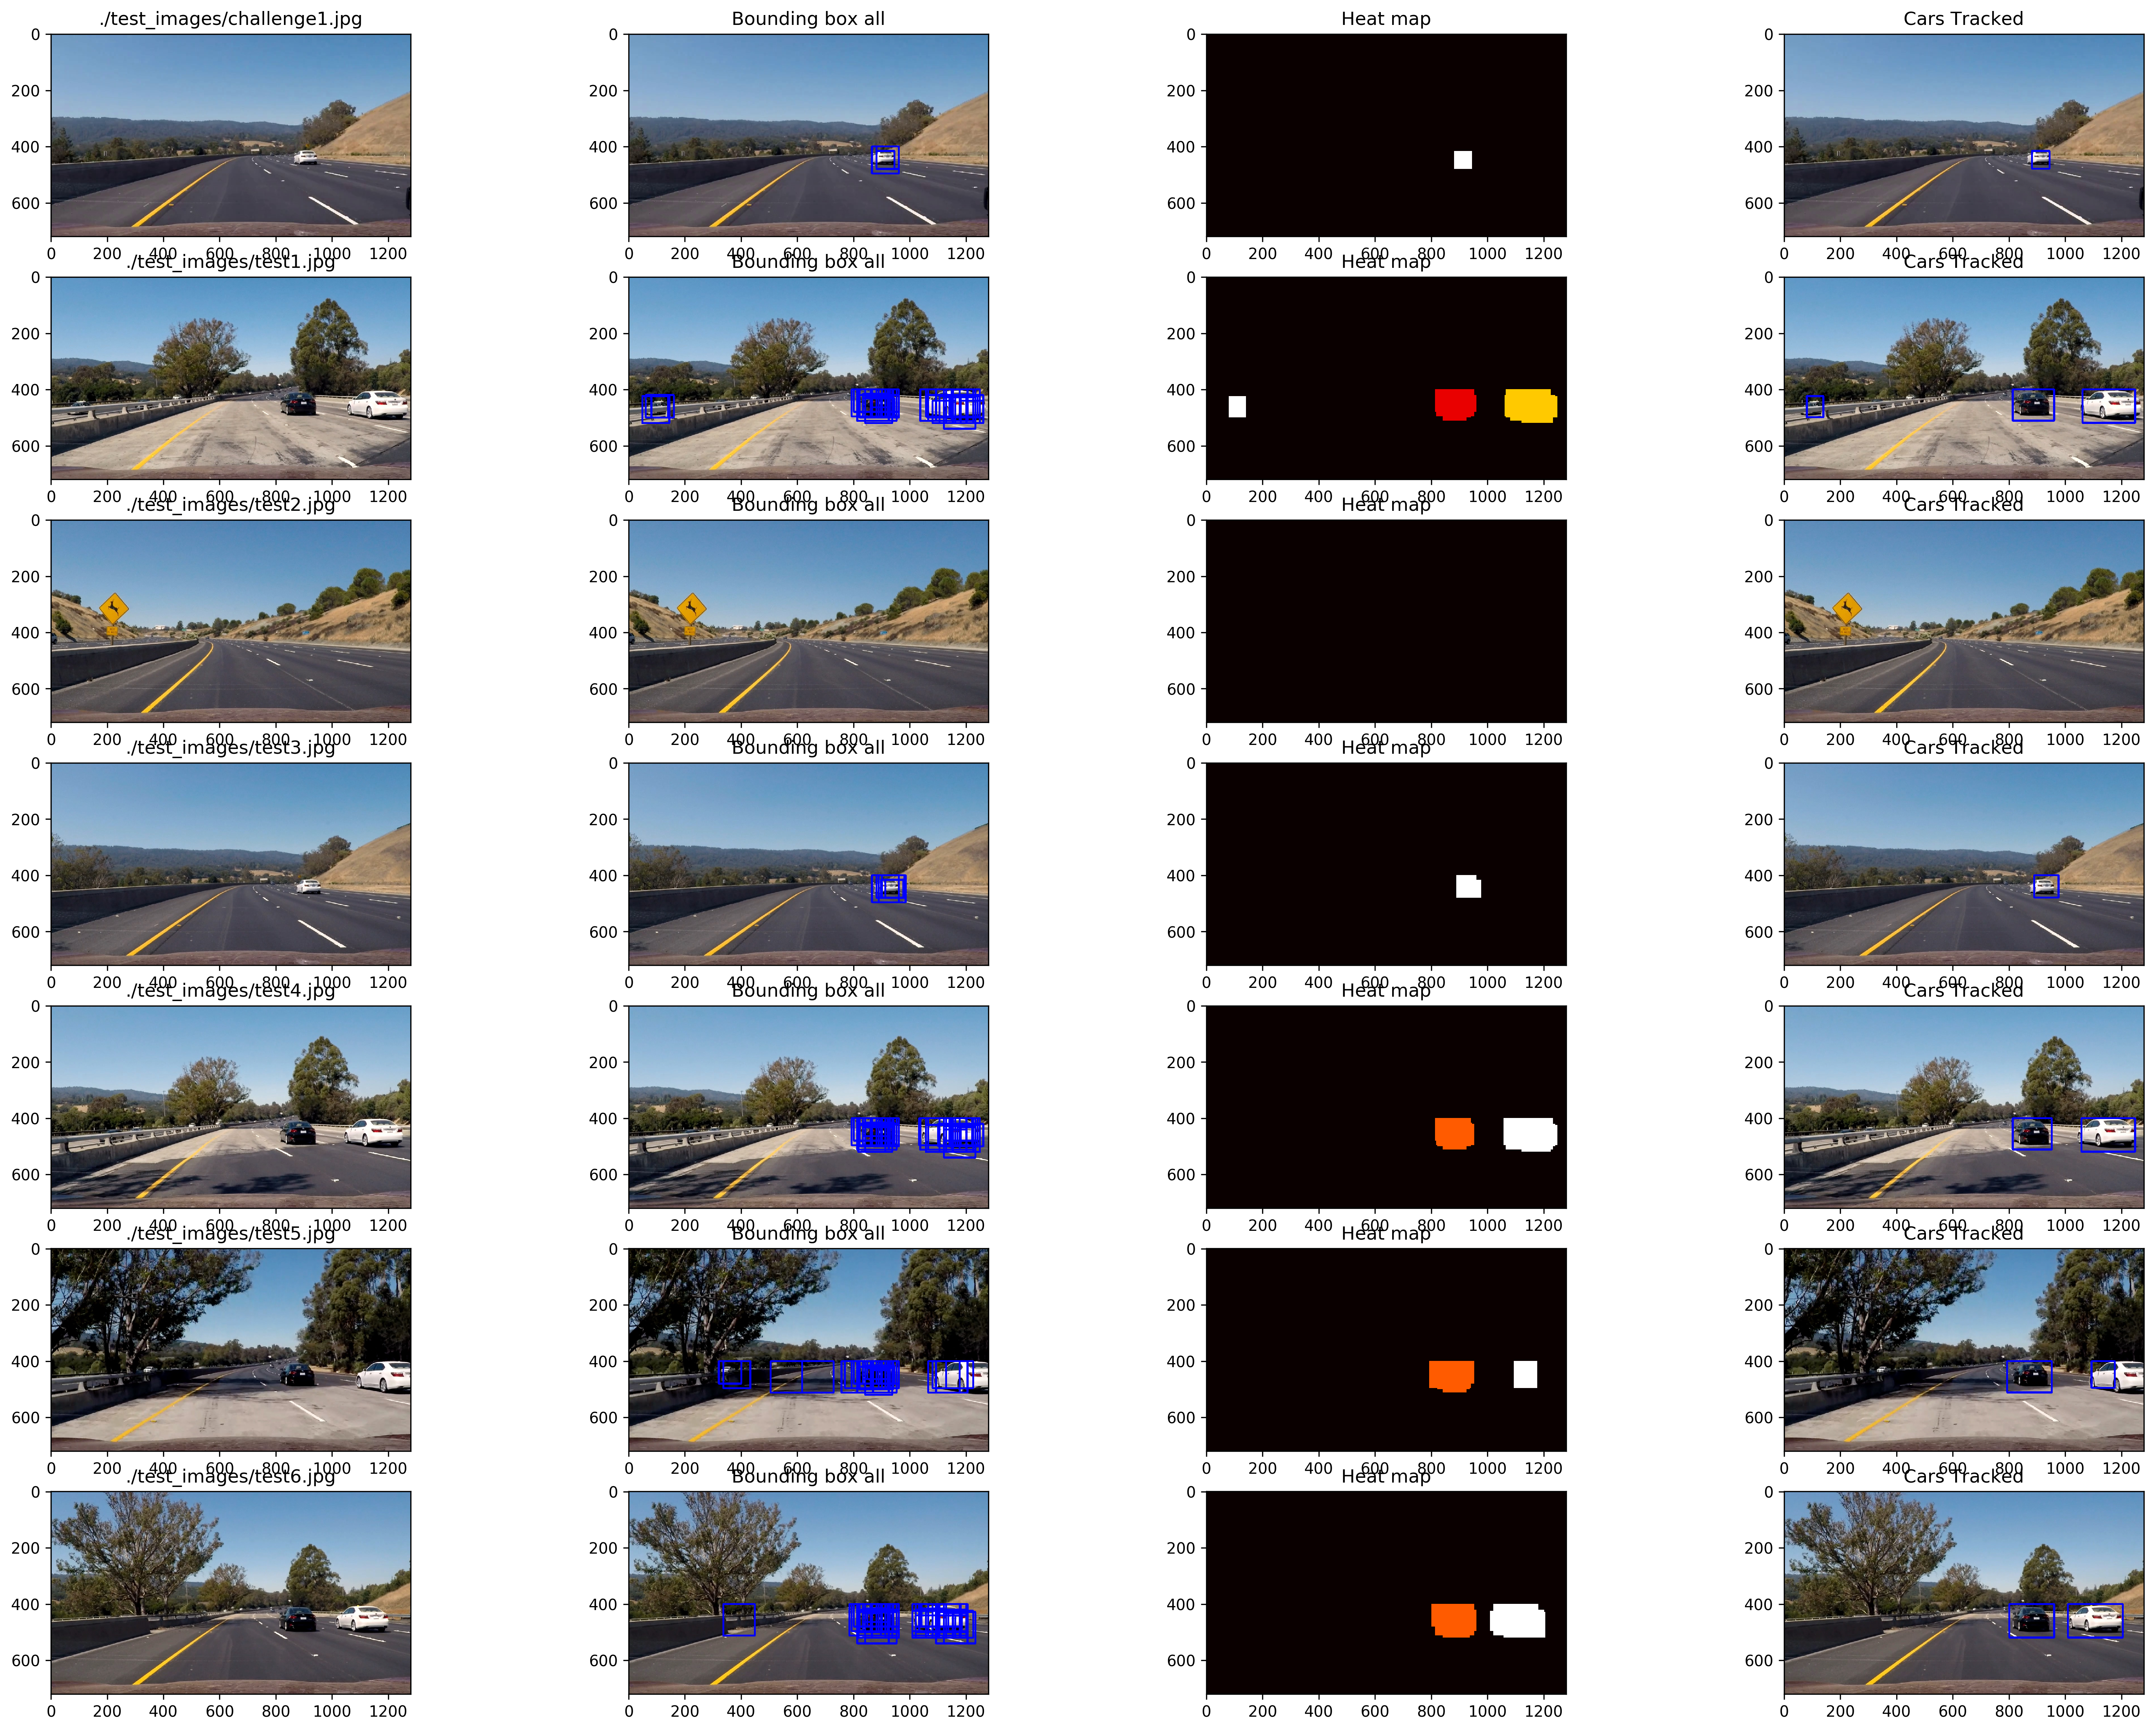

In [13]:
ystart = 400
ystop = 656
imgs = glob.glob('./test_images/*.jpg')
images = []
titles = []
scales = [1, 1.25, 1.5, 1.75]
for imgpath in imgs:
    img = mpimg.imread(imgpath)
    images.append(img)
    titles.append(imgpath)
    bboxes = []
    for scale in scales:
        bboxes_scale = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, 
                            orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if bboxes_scale != None:
            bboxes.extend(bboxes_scale)
    
    all_box_img = draw_boxes(img, bboxes)
    images.append(all_box_img)
    titles.append('Bounding box all')

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heat = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heat)

    print(labels[1], 'cars found')
#         plt.imshow(labels[0], cmap='gray')
    images.append(labels[0])
    titles.append('Heat map')

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    images.append(draw_img)
    titles.append('Cars Tracked')

fig = plt.figure(figsize=(26, 20), dpi=300)

visualize(fig, len(imgs), 4, images, titles)
plt.show()

#### Process Videos

In [83]:
class Vehicle:
    def __init__(self):
        self.bboxes = []
        self.bboxFilter = 5
        self.failedDetectCount = 0
        self.failedDetectThresh = 2

    def update_pos(self, bbox):
        if bbox == None:
            self.failedDetectCount += 1
            if self.failedDetectCount > self.failedDetectThresh:
                self.bboxes = []
        else:
            self.failedDetectCount = 0
            # check if current position is much different
            if len(self.bboxes):
                if (abs(bbox[0][0]-np.mean(self.bboxes, axis=0).astype(int)[0][0])) > 75 or \
                    (abs(bbox[1][0]-np.mean(self.bboxes, axis=0).astype(int)[1][0]) > 75):
                    self.bboxes = []

            self.bboxes.append(bbox)
            if len(self.bboxes) > self.bboxFilter:
                self.bboxes = self.bboxes[1:]

    def get_bbox(self):
        if self.bboxes != []:
            # smooth bbox
            bbox = np.mean(self.bboxes, axis=0).astype(int)
            return bbox
        else:
            return None


class VechicleDetector:
    def __init__(self):
        self.ystart = 400
        self.ystop = 656
#        self.scales = [1.25, 1.5, 1.75, 2.0]
        self.scales = [1.25, 1.30, 1.5, 1.75, 2.0]
        self.smooth_threshold = 5
        self.heat_threshold = 3
        self.smooth_bboxes = []
        self.vehicles = []
        
    def process_frame(self, img):
        bboxes = []
        for scale in self.scales:
            bboxes_scale = find_cars(img, self.ystart, self.ystop, scale, svc, X_scaler, color_space, 
                                orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            if bboxes_scale != None:
                bboxes.extend(bboxes_scale)

        all_box_img = draw_boxes(img, bboxes)

        heat = np.zeros_like(img[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat, bboxes)

        # Apply threshold to help remove false positives from current frame
        heat = apply_threshold(heat, self.heat_threshold)

        self.smooth_bboxes.append(heat)
        if (len(self.smooth_bboxes) > self.smooth_threshold):
            self.smooth_bboxes = self.smooth_bboxes[1:]
            
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        for i in range(len(self.smooth_bboxes)):
            heat = heat + self.smooth_bboxes[i]
        
        # Apply threshold to help remove false positives after smoothing over multiple frames
        #heat = apply_threshold(heat, 4)
        heat = apply_threshold(heat, 5)

        # Visualize the heatmap when displaying    
        heat = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heat)
        
        #self.update_vehicles(labels)
        
        #draw_img = self.draw_vehicle_boxes(np.copy(img))
        draw_img = self.draw_labeled_bboxes(np.copy(img), labels)
        return draw_img
    
    def update_vehicles(self, labels):
        # Iterate through all detected vehicles
        for vehicle_number in range(1, max(len(self.vehicles), labels[1]+1)):
            # Find pixels with each vehicle_number label value
            nonzero = (labels[0] == vehicle_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            if len(nonzerox):
                if ((max(nonzerox) - min(nonzerox)) / (max(nonzeroy) - min(nonzeroy))) > 0.55 or \
                    ((max(nonzeroy) - min(nonzeroy)) / (max(nonzerox) - min(nonzerox))) > 0.55:
                    # Define a bounding box based on min/max x and y
                    bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
                else:
                    bbox = None
            else:
                bbox = None
            
            # create a new vehicle object if a new vechicle detected
            if len(self.vehicles) < vehicle_number:
                self.vehicles.append(Vehicle())
            
            self.vehicles[-1].update_pos(bbox)

    def draw_vehicle_boxes(self, img):
        bboxes = []
        for vehicle in self.vehicles:
            bbox = vehicle.get_bbox()
            if bbox != None:
                bboxes.append(bbox)
        
        heat = np.zeros_like(img[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat, bboxes)
        heat = np.clip(heat, 0, 255)
        labels = label(heat)
        return self.draw_labeled_bboxes(np.copy(img), labels)
    
    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            print('car_number', car_number, (max(nonzerox) - min(nonzerox)), (max(nonzeroy) - min(nonzeroy)))
            ## Filter out if extremely small in either dimension
            if (max(nonzerox) - min(nonzerox)) > 40 and \
                    (max(nonzeroy) - min(nonzeroy)) > 40:
                    
                # Define a bounding box based on min/max x and y
                bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

                # Draw the box on the image
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

        # Return the image
        return img

In [42]:
from moviepy.video.io.VideoFileClip import VideoFileClip

detector = VechicleDetector()

videopath = 'test_video.mp4'
clip = VideoFileClip(videopath)
video_clip = clip.fl_image(detector.process_frame)
video_clip.write_videofile(videopath + '_tracked.mp4', audio=False)

[MoviePy] >>>> Building video test_video.mp4_tracked.mp4
[MoviePy] Writing video test_video.mp4_tracked.mp4


 97%|█████████▋| 38/39 [01:19<00:02,  2.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video.mp4_tracked.mp4 



In [ ]:
detector = VechicleDetector()

videopath = 'project_video.mp4'
clip = VideoFileClip(videopath)
#clip = VideoFileClip(file).subclip('00:00:13.00','00:00:27.00')
# lots of shadows
clip = VideoFileClip(videopath).subclip('00:00:32.00','00:00:38.00')
#clip = VideoFileClip(videopath).subclip('00:00:27.50','00:00:28.00')
#clip = VideoFileClip(videopath).subclip('00:00:19.00','00:00:25.00')

video_clip = clip.fl_image(detector.process_frame)
video_clip.write_videofile(videopath + '_trimmed2_4scale9_32_32_tracked.mp4', audio=False)

car_number 1 223 139
[MoviePy] >>>> Building video project_video.mp4_trimmed2_4scale9_32_32_tracked.mp4
[MoviePy] Writing video project_video.mp4_trimmed2_4scale9_32_32_tracked.mp4





  0%|          | 0/151 [00:00<?, ?it/s]


  1%|          | 1/151 [00:02<05:32,  2.21s/it]

car_number 1 231 143





  1%|▏         | 2/151 [00:04<05:32,  2.23s/it]

car_number 1 231 143





  2%|▏         | 3/151 [00:06<05:32,  2.25s/it]

car_number 1 231 143





  3%|▎         | 4/151 [00:08<05:29,  2.24s/it]

car_number 1 231 143





  3%|▎         | 5/151 [00:11<05:29,  2.26s/it]

car_number 1 231 143





  4%|▍         | 6/151 [00:13<05:25,  2.24s/it]

car_number 1 231 143





  5%|▍         | 7/151 [00:15<05:23,  2.24s/it]

car_number 1 231 143





  5%|▌         | 8/151 [00:18<05:22,  2.26s/it]

car_number 1 215 143





  6%|▌         | 9/151 [00:20<05:19,  2.25s/it]

car_number 1 215 143





  7%|▋         | 10/151 [00:22<05:17,  2.25s/it]

car_number 1 215 143





  7%|▋         | 11/151 [00:24<05:15,  2.25s/it]

car_number 1 215 139





  8%|▊         | 12/151 [00:27<05:12,  2.25s/it]

car_number 1 213 139





  9%|▊         | 13/151 [00:29<05:11,  2.26s/it]

car_number 1 213 143





  9%|▉         | 14/151 [00:31<05:10,  2.26s/it]

car_number 1 213 143





 10%|▉         | 15/151 [00:33<05:06,  2.25s/it]

car_number 1 211 143





 11%|█         | 16/151 [00:36<05:05,  2.26s/it]

car_number 1 211 143





 11%|█▏        | 17/151 [00:38<05:01,  2.25s/it]

car_number 1 203 143





 12%|█▏        | 18/151 [00:40<04:57,  2.23s/it]

car_number 1 199 143





 13%|█▎        | 19/151 [00:42<04:48,  2.19s/it]

car_number 1 207 143





 13%|█▎        | 20/151 [00:44<04:42,  2.16s/it]

car_number 1 214 143





 14%|█▍        | 21/151 [00:46<04:38,  2.14s/it]

car_number 1 207 143





 15%|█▍        | 22/151 [00:48<04:34,  2.13s/it]

car_number 1 207 143





 15%|█▌        | 23/151 [00:50<04:31,  2.12s/it]

car_number 1 207 139





 16%|█▌        | 24/151 [00:53<04:27,  2.11s/it]

car_number 1 207 139





 17%|█▋        | 25/151 [00:55<04:25,  2.11s/it]

car_number 1 200 139





 17%|█▋        | 26/151 [00:57<04:24,  2.11s/it]

car_number 1 199 139





 18%|█▊        | 27/151 [00:59<04:21,  2.11s/it]

car_number 1 206 139





 19%|█▊        | 28/151 [01:01<04:20,  2.12s/it]

car_number 1 206 139





 19%|█▉        | 29/151 [01:03<04:20,  2.14s/it]

car_number 1 195 127





 20%|█▉        | 30/151 [01:05<04:21,  2.16s/it]

car_number 1 191 139





 21%|██        | 31/151 [01:08<04:23,  2.20s/it]

car_number 1 191 139





 21%|██        | 32/151 [01:10<04:22,  2.21s/it]

car_number 1 191 139





 22%|██▏       | 33/151 [01:12<04:21,  2.21s/it]

car_number 1 191 139





 23%|██▎       | 34/151 [01:14<04:17,  2.21s/it]

car_number 1 191 139





 23%|██▎       | 35/151 [01:17<04:18,  2.22s/it]

car_number 1 195 139





 24%|██▍       | 36/151 [01:19<04:17,  2.24s/it]

car_number 1 195 139





 25%|██▍       | 37/151 [01:21<04:13,  2.23s/it]

car_number 1 195 139





 25%|██▌       | 38/151 [01:23<04:12,  2.24s/it]

car_number 1 199 139





 26%|██▌       | 39/151 [01:26<04:08,  2.22s/it]

car_number 1 195 127





 26%|██▋       | 40/151 [01:28<04:03,  2.19s/it]

car_number 1 195 127





 27%|██▋       | 41/151 [01:30<03:59,  2.17s/it]

car_number 1 175 127





 28%|██▊       | 42/151 [01:32<03:54,  2.15s/it]

car_number 1 175 127





 28%|██▊       | 43/151 [01:34<03:52,  2.15s/it]

car_number 1 175 127





 29%|██▉       | 44/151 [01:36<03:53,  2.18s/it]

car_number 1 175 127





 30%|██▉       | 45/151 [01:39<03:54,  2.21s/it]

car_number 1 179 127





 30%|███       | 46/151 [01:41<03:53,  2.22s/it]

car_number 1 187 127





 31%|███       | 47/151 [01:43<03:46,  2.18s/it]

car_number 1 186 127





 32%|███▏      | 48/151 [01:45<03:45,  2.19s/it]

car_number 1 183 127





 32%|███▏      | 49/151 [01:47<03:43,  2.19s/it]

car_number 1 195 127





 33%|███▎      | 50/151 [01:49<03:39,  2.18s/it]

car_number 1 195 127





 34%|███▍      | 51/151 [01:52<03:40,  2.21s/it]

car_number 1 195 127





 34%|███▍      | 52/151 [01:54<03:40,  2.22s/it]

car_number 1 195 127





 35%|███▌      | 53/151 [01:56<03:38,  2.23s/it]

car_number 1 195 127





 36%|███▌      | 54/151 [01:58<03:35,  2.22s/it]

car_number 1 195 127





 36%|███▋      | 55/151 [02:01<03:35,  2.24s/it]

car_number 1 195 127





 37%|███▋      | 56/151 [02:03<03:33,  2.25s/it]

car_number 1 195 127





 38%|███▊      | 57/151 [02:05<03:30,  2.24s/it]

car_number 1 195 127





 38%|███▊      | 58/151 [02:07<03:28,  2.24s/it]

car_number 1 195 127





 39%|███▉      | 59/151 [02:10<03:26,  2.24s/it]

car_number 1 195 127





 40%|███▉      | 60/151 [02:12<03:24,  2.25s/it]

car_number 1 199 127





 40%|████      | 61/151 [02:14<03:20,  2.23s/it]

car_number 1 199 127





 41%|████      | 62/151 [02:16<03:16,  2.21s/it]

car_number 1 199 127





 42%|████▏     | 63/151 [02:19<03:15,  2.22s/it]

car_number 1 199 127





 42%|████▏     | 64/151 [02:21<03:14,  2.24s/it]

car_number 1 199 127





 43%|████▎     | 65/151 [02:23<03:11,  2.23s/it]

car_number 1 219 127





 44%|████▎     | 66/151 [02:25<03:10,  2.24s/it]

car_number 1 219 127





 44%|████▍     | 67/151 [02:28<03:08,  2.25s/it]

car_number 1 219 127





 45%|████▌     | 68/151 [02:30<03:04,  2.22s/it]

car_number 1 219 127





 46%|████▌     | 69/151 [02:32<03:02,  2.23s/it]

car_number 1 219 127





 46%|████▋     | 70/151 [02:34<02:59,  2.21s/it]

car_number 1 227 127





 47%|████▋     | 71/151 [02:36<02:52,  2.16s/it]

car_number 1 227 127





 48%|████▊     | 72/151 [02:38<02:49,  2.15s/it]

car_number 1 227 127





 48%|████▊     | 73/151 [02:40<02:45,  2.12s/it]

car_number 1 227 127





 49%|████▉     | 74/151 [02:42<02:41,  2.10s/it]

car_number 1 227 127





 50%|████▉     | 75/151 [02:44<02:38,  2.08s/it]

car_number 1 227 127





 50%|█████     | 76/151 [02:46<02:34,  2.07s/it]

car_number 1 227 127





 51%|█████     | 77/151 [02:49<02:32,  2.07s/it]

car_number 1 227 127





 52%|█████▏    | 78/151 [02:51<02:30,  2.07s/it]

car_number 1 227 127





 52%|█████▏    | 79/151 [02:53<02:28,  2.07s/it]

car_number 1 227 127





 53%|█████▎    | 80/151 [02:55<02:26,  2.06s/it]

car_number 1 227 127





 54%|█████▎    | 81/151 [02:57<02:24,  2.06s/it]

car_number 1 227 127





 54%|█████▍    | 82/151 [02:59<02:21,  2.06s/it]

car_number 1 247 127





 55%|█████▍    | 83/151 [03:01<02:20,  2.06s/it]

car_number 1 247 127





 56%|█████▌    | 84/151 [03:03<02:18,  2.06s/it]

car_number 1 247 127





 56%|█████▋    | 85/151 [03:05<02:16,  2.07s/it]

car_number 1 247 123





 57%|█████▋    | 86/151 [03:07<02:14,  2.07s/it]

car_number 1 259 123





 58%|█████▊    | 87/151 [03:09<02:12,  2.08s/it]

car_number 1 267 127





 58%|█████▊    | 88/151 [03:11<02:10,  2.06s/it]

car_number 1 267 127





 59%|█████▉    | 89/151 [03:13<02:09,  2.09s/it]

car_number 1 268 127





 60%|█████▉    | 90/151 [03:15<02:06,  2.08s/it]

car_number 1 268 127





 60%|██████    | 91/151 [03:18<02:04,  2.07s/it]

car_number 1 264 127





 61%|██████    | 92/151 [03:20<02:02,  2.07s/it]

car_number 1 264 127





 62%|██████▏   | 93/151 [03:22<01:59,  2.07s/it]

car_number 1 260 127





 62%|██████▏   | 94/151 [03:24<01:58,  2.08s/it]

car_number 1 267 127





 63%|██████▎   | 95/151 [03:26<01:56,  2.08s/it]

car_number 1 267 127





 64%|██████▎   | 96/151 [03:28<01:54,  2.08s/it]

car_number 1 267 127





 64%|██████▍   | 97/151 [03:30<01:52,  2.07s/it]

car_number 1 267 127





 65%|██████▍   | 98/151 [03:32<01:49,  2.07s/it]

car_number 1 267 127





 66%|██████▌   | 99/151 [03:34<01:47,  2.07s/it]

car_number 1 271 127





 66%|██████▌   | 100/151 [03:36<01:45,  2.07s/it]

car_number 1 279 127





 67%|██████▋   | 101/151 [03:38<01:43,  2.07s/it]

car_number 1 279 127





 68%|██████▊   | 102/151 [03:40<01:41,  2.07s/it]

car_number 1 279 127





 68%|██████▊   | 103/151 [03:42<01:39,  2.07s/it]

car_number 1 279 127





 69%|██████▉   | 104/151 [03:44<01:37,  2.07s/it]

car_number 1 281 119





 70%|██████▉   | 105/151 [03:47<01:35,  2.09s/it]

car_number 1 283 119





 70%|███████   | 106/151 [03:49<01:34,  2.09s/it]

car_number 1 291 119





 71%|███████   | 107/151 [03:51<01:33,  2.13s/it]

car_number 1 291 119





 72%|███████▏  | 108/151 [03:53<01:31,  2.13s/it]

car_number 1 291 119





 72%|███████▏  | 109/151 [03:55<01:30,  2.16s/it]

car_number 1 291 119





 73%|███████▎  | 110/151 [03:57<01:29,  2.17s/it]

car_number 1 291 119





 74%|███████▎  | 111/151 [04:00<01:26,  2.16s/it]

car_number 1 307 119





 74%|███████▍  | 112/151 [04:02<01:23,  2.13s/it]

car_number 1 303 119





 75%|███████▍  | 113/151 [04:04<01:20,  2.11s/it]

car_number 1 303 119





 75%|███████▌  | 114/151 [04:06<01:17,  2.09s/it]

car_number 1 299 119





 76%|███████▌  | 115/151 [04:08<01:15,  2.09s/it]

car_number 1 299 119





 77%|███████▋  | 116/151 [04:10<01:12,  2.08s/it]

car_number 1 303 119





 77%|███████▋  | 117/151 [04:12<01:10,  2.08s/it]

car_number 1 303 119





 78%|███████▊  | 118/151 [04:14<01:08,  2.08s/it]

car_number 1 310 119





 79%|███████▉  | 119/151 [04:16<01:06,  2.09s/it]

car_number 1 311 119





 79%|███████▉  | 120/151 [04:18<01:05,  2.10s/it]

car_number 1 316 119





 80%|████████  | 121/151 [04:20<01:03,  2.13s/it]

car_number 1 316 119





 81%|████████  | 122/151 [04:23<01:01,  2.11s/it]

car_number 1 316 119





 81%|████████▏ | 123/151 [04:25<00:58,  2.10s/it]

car_number 1 328 119





 82%|████████▏ | 124/151 [04:27<00:56,  2.10s/it]

car_number 1 328 119





 83%|████████▎ | 125/151 [04:29<00:54,  2.11s/it]

car_number 1 316 119





 83%|████████▎ | 126/151 [04:31<00:52,  2.11s/it]

car_number 1 316 119





 84%|████████▍ | 127/151 [04:33<00:50,  2.11s/it]

car_number 1 328 119





 85%|████████▍ | 128/151 [04:35<00:48,  2.13s/it]

car_number 1 339 119





 85%|████████▌ | 129/151 [04:37<00:46,  2.13s/it]

car_number 1 339 119





 86%|████████▌ | 130/151 [04:39<00:44,  2.13s/it]

car_number 1 347 119





 87%|████████▋ | 131/151 [04:42<00:42,  2.15s/it]

car_number 1 347 119





 87%|████████▋ | 132/151 [04:44<00:40,  2.15s/it]

car_number 1 176 119
car_number 2 163 119





 88%|████████▊ | 133/151 [04:46<00:38,  2.17s/it]

car_number 1 176 119
car_number 2 163 119





 89%|████████▊ | 134/151 [04:48<00:37,  2.19s/it]

car_number 1 159 119
car_number 2 162 111





 89%|████████▉ | 135/151 [04:50<00:34,  2.19s/it]

car_number 1 148 119
car_number 2 162 111





 90%|█████████ | 136/151 [04:53<00:33,  2.20s/it]

car_number 1 148 119
car_number 2 170 111


#### Add Lane tracking

In [70]:
import cv2
import numpy as np
import pickle

class Tracker():
    def __init__(self, window_width, window_height, margin, xm=1, ym=1, smooth_factor=15):
        # list that stores all the past (left, right) center set values used for smoothing the output
        self.recent_centers = []

        # the window pixel width of the center values, used to count pixels inside center windows to determine curve
        #  values
        self.window_width = window_width

        # the window pixel height of the center values, used to count pixels inside center windows to determine curve
        #  values. breaks the image into vertical levels
        self.window_height = window_height

        # the pixel distance in both directions to slide (left_window + right_window) template for searching
        # average x values of the fitted line over the last n iterations
        self.margin = margin

        # meters per pixel in horizontal axis
        self.xm_per_pix = xm

        # meters per pixel in vertical axis
        self.ym_per_pix = ym

        # smooth factor
        self.smooth_factor = smooth_factor

    def find_window_centroids(self, warped):
        window_centroids = []  # Store the (left,right) window centroid positions per level
        window = np.ones(self.window_width)  # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image
        #  slice and then np.convolve the vertical image slice with the window template

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3 * warped.shape[0] / 4):, :int(warped.shape[1] / 2)], axis=0)
        l_center = np.argmax(np.convolve(window, l_sum)) - self.window_width / 2
        r_sum = np.sum(warped[int(3 * warped.shape[0] / 4):, int(warped.shape[1] / 2):], axis=0)
        r_center = np.argmax(np.convolve(window, r_sum)) - self.window_width / 2 + int(warped.shape[1] / 2)

        # Add what we found for the first layer
        window_centroids.append((l_center, r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1, (int)(warped.shape[0] / self.window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(
                warped[int(warped.shape[0] - (level + 1) * self.window_height):int(warped.shape[0] - level *
                                                                                   self.window_height), :], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference Use window_width/2 as offset
            # because convolution signal reference is at right side of window, not center of window
            offset = self.window_width / 2
            l_min_index = int(max(l_center + offset - self.margin, 0))
            l_max_index = int(min(l_center + offset + self.margin, warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center + offset - self.margin, 0))
            r_max_index = int(min(r_center + offset + self.margin, warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset
            # Add what we found for that layer
            window_centroids.append((l_center, r_center))

        self.recent_centers.append(window_centroids)
        return np.average(self.recent_centers[-self.smooth_factor:], axis=0)

    def draw_rectangles(self, window_centroids, binary):
        # If we found any window centers
        if len(window_centroids) > 0:

            # Points used to draw all the left and right windows
            l_points = np.zeros_like(binary)
            r_points = np.zeros_like(binary)

            leftx = []
            rightx = []

            # Go through each level and draw the windows
            for level in range(0, len(window_centroids)):
                leftx.append(window_centroids[level][0])
                rightx.append(window_centroids[level][1])

                # Window_mask is a function to draw window areas
                l_mask = window_mask(self.window_width, self.window_height, binary, window_centroids[level][0], level)
                r_mask = window_mask(self.window_width, self.window_height, binary, window_centroids[level][1], level)
                # Add graphic points from window mask here to total pixels found
                l_points[(l_points == 255) | (l_mask == 1)] = 255
                r_points[(r_points == 255) | (r_mask == 1)] = 255

            # Draw the results
            # add both left and right window pixels together
            template = np.array(r_points + l_points, np.uint8)

            # create a zero color channel
            zero_channel = np.zeros_like(template)

            # make window pixels green
            template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)

            # making the original road pixels 3 color channels
            warpage = np.array(cv2.merge((binary, binary, binary)),
                               np.uint8)

            # overlay the orignal road image with window results
            output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

        # If no window centers found, just display original road image
        else:
            output = np.array(cv2.merge((binary, binary, binary)), np.uint8)

        return output, leftx, rightx

    def curvature(self, image, binary, leftx, rightx, Minv):
        img_size = (image.shape[1], image.shape[0])

        yvals = range(0, binary.shape[0])
        res_yvals = np.arange(binary.shape[0] - (self.window_height / 2), 0, -self.window_height)

        left_fit = np.polyfit(res_yvals, leftx, 2)
        left_fitx = left_fit[0] * yvals * yvals + left_fit[1] * yvals + left_fit[2]
        left_fitx = np.array(left_fitx, np.int32)

        right_fit = np.polyfit(res_yvals, rightx, 2)
        right_fitx = right_fit[0] * yvals * yvals + right_fit[1] * yvals + right_fit[2]
        right_fitx = np.array(right_fitx, np.int32)

        left_lane = np.array(
            list(zip(np.concatenate((left_fitx - self.window_width / 2, left_fitx[::-1] + self.window_width / 2), axis=0),
                     np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

        right_lane = np.array(
            list(zip(np.concatenate((right_fitx - self.window_width / 2, right_fitx[::-1] + self.window_width / 2), axis=0),
                     np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

        middle_marker = np.array(
            list(zip(np.concatenate((left_fitx - self.window_width / 2, right_fitx[::-1] + self.window_width / 2), axis=0),
                     np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

        road = np.zeros_like(image)
        road_bkg = np.zeros_like(image)

        cv2.fillPoly(road, [left_lane], color=[255, 0, 0])
        cv2.fillPoly(road, [right_lane], color=[0, 0, 255])
        cv2.fillPoly(road, [middle_marker], color=[0, 255, 0])
        cv2.fillPoly(road_bkg, [left_lane], color=[255, 255, 255])
        cv2.fillPoly(road_bkg, [right_lane], color=[255, 255, 255])

        road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
        road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)

        base = cv2.addWeighted(image, 1.0, road_warped_bkg, -1.0, 0.0)
        result = cv2.addWeighted(base, 1.0, road_warped, 0.7, 0.0)
        ym_per_pix = self.ym_per_pix
        xm_per_pix = self.xm_per_pix

        curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32) * ym_per_pix,
                                  np.array(leftx, np.float32) * xm_per_pix, 2)
        curverad = ((1 + (2 * curve_fit_cr[0] * yvals[-1] * ym_per_pix + curve_fit_cr[1]) ** 2) ** 1.5) / \
                   np.absolute(2 * curve_fit_cr[0])

        camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
        center_diff = (camera_center - binary.shape[1] / 2) * xm_per_pix
        side_pos = 'left'
        if center_diff <= 0:
            side_pos = 'right'

        cv2.putText(result, "Curvature Radius = " + str(round(curverad, 3)) + '(m)', (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(result,
                    "Distance from Center =  " + str(abs(round(center_diff, 3))) + 'm ' + side_pos + ' of center',
                    (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        return result


def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0] - (level + 1) * height):int(img_ref.shape[0] - level * height),
    max(0, int(center - width / 2)):min(int(center + width / 2), img_ref.shape[1])] = 1
    return output

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary


def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)

    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    direction = np.arctan2(sobely, sobelx)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return dir_binary


def color_threshold(img, thresh_b=(155, 225), thresh_l=(210, 255)):
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:, :, 2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:, :, 0]

    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= thresh_b[0]) & (b_channel <= thresh_b[1])] = 1

    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh_l[0]) & (l_channel <= thresh_l[1])] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    return combined_binary


def apply_mask(image, ksize=3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(40, 160))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(40, 160))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 140))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.8, 1.3))
    color_binary = color_threshold(image)

    combined = np.zeros_like(gradx)
    combined[((gradx == 1) & (grady == 1)) | (color_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 255

    return combined


def birds_eye_perspective(image):
    img_size = (image.shape[1], image.shape[0])

    src = np.float32([[490, 482], [810, 482],
                      [1240, 720], [40, 720]])
    dst = np.float32([[0, 0], [1280, 0],
                      [1160, 720], [120, 720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    return M, Minv, warped


class Processor():
    def __init__(self):
        # list that stores all the past (left, right) center set values used for smoothing the output
        self.tracker = Tracker(window_width=20, window_height=120, margin=25, xm=3.7/700, ym=30/720,
                                smooth_factor=20)

        dist_pickle = pickle.load(open('calibration_pickle.p', 'rb'))
        self.matrix = dist_pickle['matrix']
        self.distances = dist_pickle['distances']

    matrix = []
    distances = []

    # Input expects a RGB image
    def process_image(self, image):
        # Convert to BGR
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Undistort the image
        image = cv2.undistort(image, self.matrix, self.distances, None, self.matrix)

        # Warp the image
        M, Minv, warped = birds_eye_perspective(image)

        # Apply thresholding functions
        binary = apply_mask(warped)

        # Get the lane window centroids and draw them
        window_centroids = self.tracker.find_window_centroids(binary)

        lanemarked, leftx, rightx = self.tracker.draw_rectangles(window_centroids, binary)

        return binary, leftx, rightx, Minv

    def track(self, image, binary, leftx, rightx, Minv):
        # Track the lanes and compute curvature and position
        tracked = self.tracker.curvature(image, binary, leftx, rightx, Minv)

        # Convert the result back to RGB
        result = cv2.cvtColor(tracked, cv2.COLOR_BGR2RGB)
        return result


In [ ]:
vehicle_detector = VechicleDetector()
lane_processor = Processor()

def lane_track_vehicle_detect(img):
    vehicle_detector.process_frame(np.copy(img))
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    binary, leftx, rightx, Minv = lane_processor.process_image(img_bgr)
    output = lane_processor.track(img_bgr, binary, leftx, rightx, Minv)
    output = vehicle_detector.draw_vehicle_boxes(output)
    return output

videopath = 'test_video.mp4'
clip = VideoFileClip(videopath)#.subclip('00:00:37.00','00:00:43.00')
video_clip = clip.fl_image(lane_track_vehicle_detect)
video_clip.write_videofile(videopath + 'all_tracked.mp4', audio=False)